In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import beta

O conjunto de dados abaixo tem distribuição de Bernoulli, com um parâmetro desconhecido p, e representa a lista de presença de uma das aulas da disciplina de Estatística, após um mês de quarentena e aulas à distância. Deseja-se estimar qual a proporção de alunos segue no curso, assistindo às aulas à distância. Faça análises inferenciais clássicas e baysianas para obter as estimativas pontuais e intervalares do parâmetro de interesse

In [4]:
data = '''
[1 1 1 1 1 1 0 1 1 0 0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 0 1 0 1 1 1 0 1 1 1 1 0
 1 1 1 1 1 1 0 1 1 1 1 1 1 0 1 1 1 0 1 0 0 0 0 0 1 1 0 0 1 1 1 1 1 1 0 1 0
 1 1 1 0 1 1 1 1 1 1 0 0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 1 1
 1 1 1 1 0 1 1 1 1 0 1 1 0 1 1 1 0 1 0 1 0 1 1 1 1 0 1 0 0 1 1 0 1 0 1 1 0
 1 1]
'''
data = [int(c) for c in data if c.isdigit()]
data = np.array(data)
data[:10]

array([1, 1, 1, 1, 1, 1, 0, 1, 1, 0])

## - Método Bayesiano

Para calcular nossa distribuição posteriori, precisamos da função de Verossimilhança e a distribuição Priori de $\theta$.

A função de Verossimilhança já foi dada, é a distribuição Binomial.

Então, nos resta decidir uma distribuição a Priori.

![documento](distribuicoes.png)

Vamos pensar, quais seriam valores prováveis de p para esse problema?

Podemos considerar muitas coisas, como:

- a dificuldade da aulas: deve gerar uma grande variação de aderência, proporcional a diversidade de alunos com diferentes formações. Ou seja, aqui estamos pensando em o quão larga (desvio padrão) será a distribuição.

- o fato de ser EAD: deve existir um proporção natural de presença em cursos EAD no geral. (uns 70%?)

- o fato de ser o segundo bimestre do curso: provavelmente quem abandonaria a disciplina, o faria no primeiro bimestre. Então isso não deve afetar muito.

- e o fato de estar em uma quarentena: talvez alguns alunos precisem deixar alguma aula de lado para focar em cuidar da família ou tenham dificuldade de acesso à internet.

Se olharmos, o gráfico das distribuições Beta abaixo, parece que a quarta distribuição (a = 8, b = 4), se parece com o que seria "esperado".

Note que esse processo é bem subjetivo.

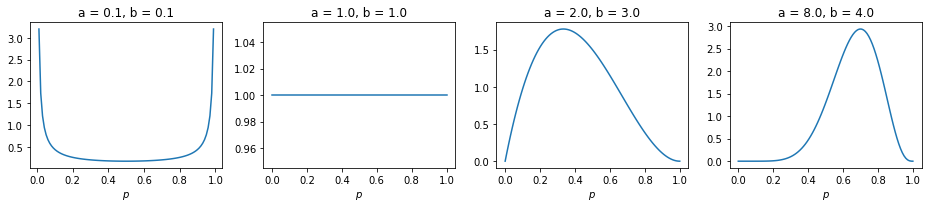

In [8]:
# Conjuntos de parâmetros da priori para teste
a_b_params = ((0.1, 0.1), (1, 1), (2, 3), (8, 4))
p = np.linspace(0, 1, 100)

# Plota as densidades da Beta para cada conjunto de parâmetros
plt.figure(figsize=(13,3))
for i, (a, b) in enumerate(a_b_params):
    plt.subplot(1, len(a_b_params), i+1)

    prior = beta(a, b)

    plt.plot(p, prior.pdf(p))    
    plt.xlabel(r'$p$')
    plt.title("a = {:.1f}, b = {:.1f}".format(a, b))
    plt.tight_layout()


Agora basta consultar a Tabela anterior (ou slide 17 da apresentação da semana 8), e teremos a fórmula de nossa distribuição posteriori,pois nesse caso a Beta é uma distribuição conjugada

In [10]:
a = 8
b = 4
n = len(data)
k = data.sum()
posteriori = beta(8 + k, 4 + n - k) 

In [13]:
# Para encontrar o valor que minimiza a perda quadrática, calculamos a média da distribuição e encontramos o estimador bayesiano EAP (Esperança a posteriori)
print('Média:', posteriori.mean())

# E para calcular um intervalo de credibilidade, decidimos uma probabilidade 
# Por exemplo 95% para a credibilidade
# Uma maneira seria definir que 2,5% de cada cauda como os limites do intervalo (chamado intervalo simétrico)
# Este método é válido quando a posteriori se aproxima de uma distribuição simétrica, pois nesse caso tende a gerar o intervalo com menor amplitude
# A seguire, apresentamos outra solução com um intervalo de credibilidade de menor amplitude.
print('Intervalo com 95% de credibilidade: (%.3f, %.3f)' % (posteriori.ppf(.025), posteriori.ppf(.975)))

Média: 0.7407407407407407
Intervalo com 95% de credibilidade: (0.671, 0.805)


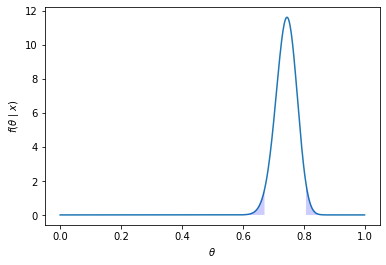

In [16]:
import matplotlib.colors as clrs

# Eixo x entre 0 e 1 de .002 em .002.
p = np.arange(0,1, 0.002)

# Define qual é a posteriori
f_p = posteriori.pdf(p) # f(p) dado x, x são nossos dados

# Constrói o gráfico da posteriori 
plt.plot(p, f_p)

alpha_e = (p <= posteriori.ppf(.025))
alpha_d = (p >= posteriori.ppf(.975))
draw_params = {'facecolor' : clrs.to_rgba(c = (0, 0, 1, 0.2))}, 'zorder' = 10}
plt.fill_between(p[alpha_e], f_p[alpha_e], **draw_params)
plt.fill_between(p[alpha_d], f_p[alpha_d], **draw_params)

plt.xlabel(r'$\theta$')
plt.ylabel(r'$f(\theta \mid x)$')
plt.show();

<hr>

Outra forma de solucionar pelo método bayesiano, é encontrando o máximo da posteriori, ou seja, o MAP.

In [6]:
import pymc3

# Cria o modelo com priori Beta(alpha,beta) e verossimilhança Bernoulli(p)
# Usemos a mesma priori que fixamos anteriormente: Beta(8,4)
def create_model_pymc3(data):
    with pymc3.Model() as model: 
        p = pymc3.Beta('p', alpha=8, beta=4)
        bernoulli = pymc3.Bernoulli('bernoulli',p=p, observed=data)
    return model

model = create_model_pymc3(data)

# Estima a probabilidade de sucesso da Bernoulli por MAP
map_estimate = pymc3.find_MAP(model=model)
map_estimate

WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
C:\Users\Mariana\Anaconda3\lib\site-packages\theano\configdefaults.py:560: UserWarning: DeprecationWarning: there is no c++ compiler.This is deprecated and with Theano 0.11 a c++ compiler will be mandatory
  warnings.warn("DeprecationWarning: there is no c++ compiler."
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
C:\Users\Mariana\Anaconda3\lib\site-packages\dask\config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) o

{'p_logodds__': array(1.06555143), 'p': array(0.74375)}

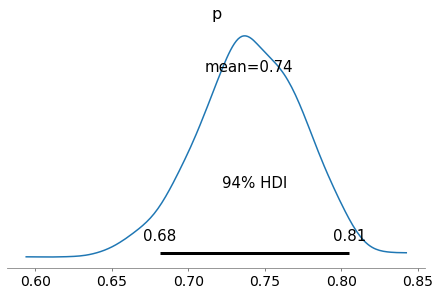

In [8]:
# Usa MCMC para gerar observações da posteriori
with model:
    trace = pymc3.sample(1000, tune=1000, cores=1)
    
# Representa a posteriori, a média e o intervalo de credibilidade com menor amplitude, denotado por HDI (por simulação MCMC) 
pymc3.plot_posterior(trace);

## - Método Clássico

In [1]:
from scipy import stats
from math import sqrt
import numpy as np
import matplotlib.pyplot as plt

In [24]:
# segue abaixo o IC(95%) calculado para a proporção (usando o estimador p_chapéu para o cálculo da variância)
# (Ver aula 4, slide 17, para encontrar mais detalhes sobre esse método)
import statsmodels.stats.proportion as smp

n = len(data)
X_barra = sum(data) / n

lower, upper = smp.proportion_confint (sum(data), n, alpha=0.05, method='normal')
print(lower,upper)

0.6770662223494937 0.8162671109838397


In [5]:
# Além disso, nossa estivamtiva de máxima verossimilhança para a proporção de alunos que segue no curso é justamente a média amostral
np.mean(data) # que é X_barra

0.7466666666666667